# ECBME 4060: Genomic Science
### Extraction of psuedo-cancer antigen from mini-challenge mutation data

In [87]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio.Seq import Seq
from Bio import Alphabet
from Bio.Alphabet import IUPAC, ProteinAlphabet
from mhcflurry import Class1AffinityPredictor
import operator
import math
import scipy.stats as scp
DATA = "../mini_challenge_data/"

In [3]:
clin_test = pd.read_csv(DATA + "clinical_test.txt",sep = "\t")
clin_train = pd.read_csv(DATA + "clinical_train.txt",sep = "\t")

In [4]:
clin_train.race.value_counts()

WHITE                               606
[Not Available]                      86
BLACK OR AFRICAN AMERICAN            65
[Not Evaluated]                      39
ASIAN                                13
[Unknown]                             6
AMERICAN INDIAN OR ALASKA NATIVE      1
Name: race, dtype: int64

In [5]:
mut_train = pd.read_csv(DATA + "mut_train.txt", sep="\t")
mut_test = pd.read_csv(DATA + "mut_test.txt", sep="\t")

/Users/jasonmohabir/Desktop/Fall 2019/genomic_science/genomic_science/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (56,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The majority of the samples are WHITE and the majority of the mutations are SNPs of which Missense Mutations are the plurality.

In [72]:
clin_test.race.value_counts()

WHITE                        136
[Not Available]               22
BLACK OR AFRICAN AMERICAN     18
[Not Evaluated]               11
ASIAN                          4
Name: race, dtype: int64

In [122]:
mut_test.Variant_Type.value_counts()

SNP    64728
DEL     1747
INS      649
Name: Variant_Type, dtype: int64

In [123]:
mut_test.Variant_Classification.value_counts()

Missense_Mutation         39381
Silent                    13461
Nonsense_Mutation          3144
Intron                     2068
3'UTR                      2043
Frame_Shift_Del            1316
RNA                        1277
5'UTR                      1212
Splice_Site                1142
Splice_Region               718
Frame_Shift_Ins             459
5'Flank                     326
3'Flank                     277
In_Frame_Del                128
Translation_Start_Site       62
Nonstop_Mutation             50
In_Frame_Ins                 48
IGR                          12
Name: Variant_Classification, dtype: int64

In [21]:
cols = ['patient_id','Amino_acids','Variant_Type','Variant_Classification','IMPACT','Hugo_Symbol','HGVSc','HGVSp','SWISSPROT']
mut_parsed_test = mut_test[cols]
mut_parsed_train = mut_train[cols]

In [15]:
'''
Pull down protein sequence from Uniprot
'''

def get_prot(swissprot):

    uni_prot = swissprot

    import httplib2 as http
    import json

    try:
        from urlparse import urlparse
    except ImportError:
        from urllib.parse import urlparse

    headers = {
            'Accept': 'application/rdf+xml',
    }

    uri = 'https://www.uniprot.org'
    path = '/uniprot/%s.fasta'%(uni_prot)
    target = urlparse(uri+path)
    method = 'GET'
    body = ''

    h = http.Http()

    response, content = h.request(
            target.geturl(),
            method,
            body,
            headers)

    record = "".join(content.decode("utf-8").split('\n')[1:])
    return(record)


In [16]:
'''
Given a patient ID, find all mutations in protein coding genes. 
    - If a missense mutation, then change the mutated amino acid
    - Extract a 10 aminoacid antigen 
    
'''

def get_pca(test_id,pca_size):

    flank = int(pca_size / 2)

    mut_test = mut_parsed[mut_parsed.patient_id == test_id]
    mut_test = mut_test.fillna(0)
    mut_filt = mut_test[~np.array(mut_test.SWISSPROT == 0)]
    mut_filt = mut_filt[~np.array(mut_filt.HGVSp == 0)]
    ctr = 0
    failed = 0

    psuedo_cancer_antigen = []


    for index,row in mut_filt.iterrows():
        mutation_index = int(''.join(list(filter(str.isdigit, row.HGVSp))))
        try:
            prot_seq = get_prot(row.SWISSPROT)
            mut_nucleotide = row.Amino_acids.split("/")[1]
            new_seq = prot_seq[:mutation_index-1] + mut_nucleotide + prot_seq[mutation_index:]
            native_antigen = prot_seq[mutation_index-1 - flank : mutation_index-1 + flank]
            tumor_antigen = new_seq[mutation_index-1 -flank : mutation_index-1 + flank].upper()

            if Alphabet._verify_alphabet(Seq(tumor_antigen,Alphabet.IUPAC.protein)):
                psuedo_cancer_antigen += [tumor_antigen]
            else:
                print(test_id,row.Hugo_Symbol,tumor_antigen,'Invalid pca')

        except:
            print(test_id,row.Hugo_Symbol,"Failed to get antigen")


    len_bool = [len(a) >= 8 and len(a) <= 15 for a in psuedo_cancer_antigen]
    filt_pca = list(np.array(psuedo_cancer_antigen)[len_bool])

    return filt_pca


### Correlation of Mutation Burden to MHC-I Binding Affinity
---
The psuedo cancer antigens for each patient were calculated. 

The affinity of this antigen to the most common Caucasian HLA gene A0101 was predicted. 
The antigen with the best score was saved. 

Each patient ID was provided as a commandline argument to the 'pca.py' file. An array job was run on the Higher Performance Computer cluster at the Center for **Computational Biology and and Bioinformatics** for each pca.py. 

In [89]:
res = pd.read_csv('best_pca.txt',sep="\n",header=None,names = {'pca_results'})
res['pca_results'] = res['pca_results'].apply(lambda x: eval(x))

In [90]:
pca_id = pd.read_csv('test_id',sep="\n",header=None,names = {'patient_id'})
pca_id['pca_results'] = res.pca_results

In [91]:
mut_filt_test = mut_parsed_test[mut_parsed_test.Variant_Classification == 'Missense_Mutation']

Calculate TMB for TEST samples

In [92]:
tmb = mut_filt_test.groupby("patient_id").agg({"SWISSPROT": pd.Series.count}).reset_index()
tmb

,patient_id,SWISSPROT
0,TEST_0001,387
1,TEST_0002,575
2,TEST_0003,262
3,TEST_0004,24
4,TEST_0005,494
...,...,...
170,TEST_0186,1067
171,TEST_0187,180
172,TEST_0188,412
173,TEST_0189,207


In [93]:
comb = pd.merge(pca_id,tmb, on="patient_id")
comb = pd.merge(comb,clin_test[['race','patient_id']] , on="patient_id")

In [94]:
comb['nanomolar_affinity'] = [i[1] for i in list(comb.pca_results)]
comb['binding_affinity'] = [ (1- math.log(i[1],50000)) for i in list(comb.pca_results)]
comb['best_pseudo_antigen'] = [i[0] for i in list(comb.pca_results)]

In [95]:
comb.sort_values('binding_affinity',ascending=False)

,patient_id,pca_results,SWISSPROT,race,nanomolar_affinity,binding_affinity,best_pseudo_antigen
104,TEST_0143,"(YSDGDHTLIY, 3.6548490134146285)",232,WHITE,3.654849,0.880214,YSDGDHTLIY
71,TEST_0181,"(FTEKLCPLFY, 4.65173082494858)",138,WHITE,4.651731,0.857923,FTEKLCPLFY
170,TEST_0155,"(VTDEYFMSMY, 4.938002444170966)",89,WHITE,4.938002,0.852404,VTDEYFMSMY
0,TEST_0147,"(CSDIRSNSYY, 6.050991236315854)",171,WHITE,6.050991,0.833617,CSDIRSNSYY
124,TEST_0081,"(YSSEVLTLWY, 6.587101922445749)",232,BLACK OR AFRICAN AMERICAN,6.587102,0.825772,YSSEVLTLWY
...,...,...,...,...,...,...,...
18,TEST_0128,"(FLESCVEVIL, 13818.434648121922)",214,WHITE,13818.434648,0.118858,FLESCVEVIL
119,TEST_0185,"(NDWIITPSGY, 13870.293949560653)",208,BLACK OR AFRICAN AMERICAN,13870.293950,0.118512,NDWIITPSGY
171,TEST_0072,"(VVDELYMIGE, 15018.90985724676)",103,WHITE,15018.909857,0.111159,VVDELYMIGE
26,TEST_0177,"(LNNQIQELFI, 15916.33541361378)",144,WHITE,15916.335414,0.105795,LNNQIQELFI


Due to majority of patients being WHITE, focus on that subset.

In [96]:
race_filt_test = comb[comb.race == 'WHITE']

Looking at the TRAIN values

In [97]:
#done = pd.read_csv('train_ids_done.txt',sep="\n",header=None,names = {'pca_results'})
res = pd.read_csv('best_pca_train.txt',sep="\n",header=None,names = {'pca_results'})
pca_id = pd.read_csv('train_ids_done.txt',sep="\n",header=None,names = {'patient_id'})
pca_id['pca_results'] = res.pca_results

In [98]:
mut_filt_train = mut_parsed_train[mut_parsed_train.Variant_Classification == 'Missense_Mutation']
mut_filt_train

,patient_id,Amino_acids,Variant_Type,Variant_Classification,IMPACT,Hugo_Symbol,HGVSc,HGVSp,SWISSPROT
1,TRAIN_0693,F/L,SNP,Missense_Mutation,MODERATE,TARDBP,c.678C>A,p.Phe226Leu,Q13148
2,TRAIN_0693,S/I,SNP,Missense_Mutation,MODERATE,SZT2,c.4157G>T,p.Ser1386Ile,Q5T011
5,TRAIN_0693,I/T,SNP,Missense_Mutation,MODERATE,MYSM1,c.641T>C,p.Ile214Thr,Q5VVJ2
6,TRAIN_0693,Q/H,SNP,Missense_Mutation,MODERATE,AMIGO1,c.618G>C,p.Gln206His,Q86WK6
9,TRAIN_0693,E/A,SNP,Missense_Mutation,MODERATE,RHBG,c.1358A>C,p.Glu453Ala,Q9H310
...,...,...,...,...,...,...,...,...,...
274056,TRAIN_0679,A/V,SNP,Missense_Mutation,MODERATE,MAML2,c.3068C>T,p.Ala1023Val,Q8IZL2
274058,TRAIN_0679,P/L,SNP,Missense_Mutation,MODERATE,CCDC62,c.1700C>T,p.Pro567Leu,Q6P9F0
274060,TRAIN_0679,D/E,SNP,Missense_Mutation,MODERATE,TRAV23DV6,c.321T>A,p.Asp107Glu,NaN
274065,TRAIN_0679,S/C,SNP,Missense_Mutation,MODERATE,SRRM2,c.5153C>G,p.Ser1718Cys,Q9UQ35


Calculate TMB for TRAIN samples

In [99]:
tmb = mut_filt_train.groupby("patient_id").agg({"SWISSPROT": pd.Series.count}).reset_index()
tmb

,patient_id,SWISSPROT
0,TRAIN_0001,221
1,TRAIN_0002,249
2,TRAIN_0003,1261
3,TRAIN_0004,85
4,TRAIN_0005,146
...,...,...
726,TRAIN_0811,168
727,TRAIN_0812,64
728,TRAIN_0813,171
729,TRAIN_0814,78


In [100]:
comb = pd.merge(pca_id,tmb, on="patient_id")
comb = pd.merge(comb,clin_train[['race','patient_id']] , on="patient_id")

In [101]:
#Filter out patients that failed PCA
comb = comb[~comb.pca_results.str.contains('TRAIN')]
comb['pca_results'] = comb['pca_results'].apply(lambda x: eval(x))
comb['nanomolar_affinity'] = [i[1] for i in list(comb.pca_results)]
comb['binding_affinity'] = [ (1- math.log(i[1],50000)) for i in list(comb.pca_results)]
comb['best_pseudo_antigen'] = [i[0] for i in list(comb.pca_results)]
comb = comb.sort_values('binding_affinity',ascending=False)
race_filt_train = comb[comb.race == 'WHITE']
#Filter out patients that are not WHITE

In [108]:
#Combine the samples
race_filt_train_test = race_filt_train.append(race_filt_test)

[Text(0, 0.5, 'Missense Mutation Load'),
 Text(0.5, 0, '(nM) Binding Affinity'),
 Text(0.5, 1.0, 'Race Filtered MHC-I Binding Affinity | COMBINE')]

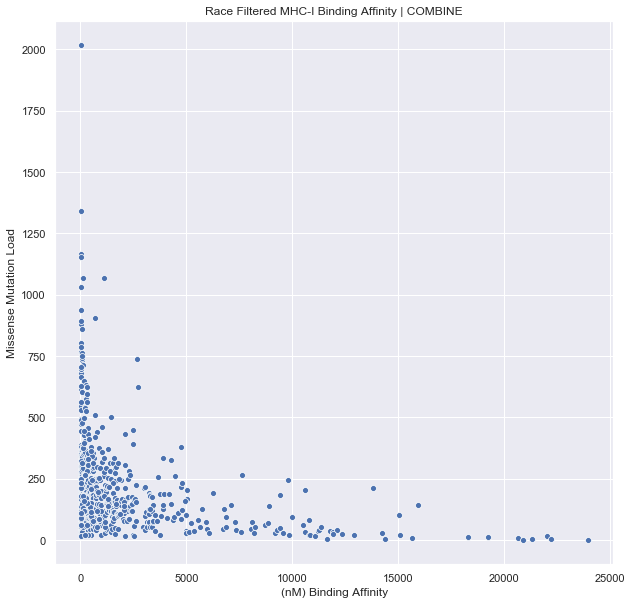

In [109]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="nanomolar_affinity", y="SWISSPROT", data=race_filt_train_test)
ax.set(title='Race Filtered MHC-I Binding Affinity | COMBINE',xlabel='(nM) Binding Affinity', ylabel='Missense Mutation Load')

[Text(0, 0.5, 'Missense Mutation Load'),
 Text(0.5, 0, 'Binding Strength'),
 Text(0.5, 1.0, 'Race Filtered MHC-I Binding Affinity | COMBINE')]

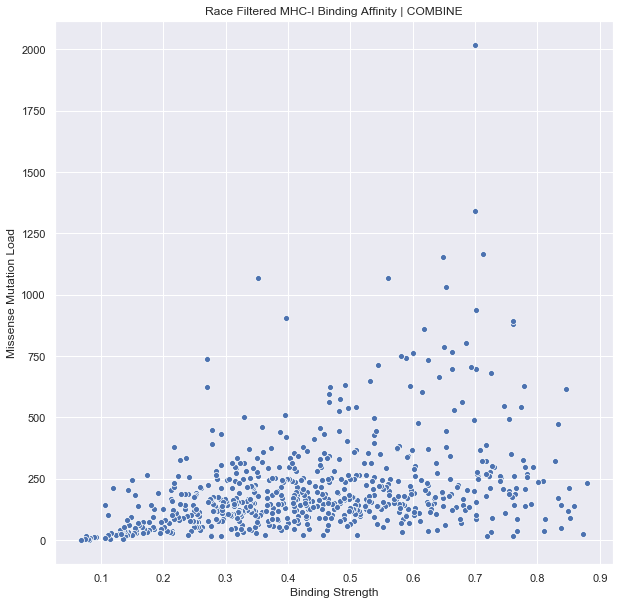

In [110]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(x="binding_affinity", y="SWISSPROT", data=race_filt_train_test)
ax.set(title='Race Filtered MHC-I Binding Affinity | COMBINE',xlabel='Binding Strength', ylabel='Missense Mutation Load')

In [113]:
print("Pearson Affinity vs. TMB [RACE FILTER|TRAIN+TEST]:",scp.pearsonr(race_filt_train_test.nanomolar_affinity,race_filt_train_test.SWISSPROT))
print("Pearson Strength vs. TMB [RACE FILTER|TRAIN+TEST]:",scp.pearsonr(race_filt_train_test.binding_affinity,race_filt_train_test.SWISSPROT))

Pearson Affinity vs. TMB [RACE FILTER|TRAIN+TEST]: (-0.2977612784441511, 4.846393860305012e-15)
Pearson Strength vs. TMB [RACE FILTER|TRAIN+TEST]: (0.3569617853412868, 2.3471016817526527e-21)


In [114]:
race_filt_train_test

,patient_id,pca_results,SWISSPROT,race,nanomolar_affinity,binding_affinity,best_pseudo_antigen
575,TRAIN_0174,"(YTDALHWYYY, 3.9553611219019627)",25,WHITE,3.955361,0.872911,YTDALHWYYY
226,TRAIN_0388,"(YTDTGLLAEY, 5.011419814320054)",212,WHITE,5.011420,0.851040,YTDTGLLAEY
104,TRAIN_0086,"(VSDLDSCHLY, 5.1507085240801365)",120,WHITE,5.150709,0.848506,VSDLDSCHLY
249,TRAIN_0372,"(LMDIYATLSY, 5.330570545342833)",617,WHITE,5.330571,0.845333,LMDIYATLSY
608,TRAIN_0767,"(LTDLESGAEY, 5.7892434488918)",49,WHITE,5.789243,0.837704,LTDLESGAEY
...,...,...,...,...,...,...,...
167,TEST_0109,"(YTSIVVELLL, 877.2023262518329)",87,WHITE,877.202326,0.373671,YTSIVVELLL
170,TEST_0155,"(VTDEYFMSMY, 4.938002444170966)",89,WHITE,4.938002,0.852404,VTDEYFMSMY
171,TEST_0072,"(VVDELYMIGE, 15018.90985724676)",103,WHITE,15018.909857,0.111159,VVDELYMIGE
172,TEST_0184,"(WSSVSKTLIF, 148.36194074403218)",396,WHITE,148.361941,0.537915,WSSVSKTLIF
